The purpose of this code is to calculate the number of affected guides in each individual for a wide range of CRISPR libraries.

In [4]:
#Arguments/Parameters
working_dir = "/home/jupyter/Ancestry/"
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET')

In [2]:
#Set up the environment

#load libraries
library(vcfR)
library(tidyverse)

#build functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
#Create the directory structure

system(glue::glue("
cd {working_dir}

#Build the master directory if it doesn't exist
if [ ! -d '{working_dir}/figures' ] 
then
mkdir figures
fi
"))

In [5]:
#Manually go through all of the directories and load in 'affected guides per person' data
#This part is currently hardcoded, in the future it will be useful to generalize it, but for now I just care about getting the data

paste(working_dir, "/filtered_output/avana14", sep ="") %>% setwd()
avana <- read.table('avana14_guide_level_matrix.txt', sep = "\t", header = T)

paste(working_dir, "/filtered_output/calabrese", sep ="") %>% setwd()
calabrese <- read.table('calabrese_guide_level_matrix.txt', sep = "\t", header = T)

paste(working_dir, "/filtered_output/minilibcas9", sep ="") %>% setwd()
minilibcas9 <- read.table('minilibcas9_guide_level_matrix.txt', sep = "\t", header = T)

paste(working_dir, "/filtered_output/sanger", sep ="") %>% setwd()
sanger <- read.table('sanger_guide_level_matrix.txt', sep = "\t", header = T)

paste(working_dir, "/filtered_output/tko", sep ="") %>% setwd()
tko <- read.table('tko_guide_level_matrix.txt', sep = "\t", header = T)

paste(working_dir, "/filtered_output/gecko", sep ="") %>% setwd()
gecko <- read.table('gecko_guide_level_matrix.txt', sep = "\t", header = T)


In [6]:
#Combine all of the datasets into a named list so that it is easier to work with
matrix.list <- NULL
matrix.list[[1]] <- avana
matrix.list[[2]] <- calabrese
matrix.list[[3]] <- minilibcas9
matrix.list[[4]] <- sanger
matrix.list[[5]] <- tko
matrix.list[[6]] <- gecko

names(matrix.list) <- c("avana", "calabrese", "minilibcas9", "sanger", "tko", "gecko")


In [7]:
#Massage all of the data frames in the list so that they are formatted properly for our downstream analysis
matrix.list <- lapply(matrix.list, function(x){
    
    x <- x[,-1] #drop the gene ID column since we don't need it for this analysis
    colnames(x) <- gsub("\\.", "-", colnames(x)) #R replaced the '-' with '.' on loading, so fix that
    colnames(x) <- gsub("v3-1--", "v3\\.1::", colnames(x)) #I converted the . to - here by mistake, when it really should be a ., so just change it back.
    x
})

In [13]:
##Load in the sample annotation file

setwd("/home/jupyter/Ancestry/raw_data/hgdp")
sample.annotation <- read.table('gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.tsv.bgz', sep = "\t", header = T)

In [15]:
#Calculate the number of affected guides in each sample

affected.guides.per.sample <- lapply(matrix.list, function(x){
    
    apply(x, 2, sum) %>% as.vector()
    
})



In [16]:
##Normalize affected.guides.per.sample so that it is normalized to be the fraction of the library that is affected, rather than the total number of guides

#load the bed files and then calculate the number of guides in each bed file
paste(working_dir, "/filtered_output/avana14", sep ="") %>% setwd()
avana.num.guides <- read.table('Avana14_filtering.bed', sep = "\t", header = T) %>% nrow()

paste(working_dir, "/filtered_output/calabrese", sep ="") %>% setwd()
calabrese.num.guides <- read.table('calabrese_filtering.bed', sep = "\t", header = T) %>% nrow()

paste(working_dir, "/filtered_output/minilibcas9", sep ="") %>% setwd()
minilibcas9.num.guides <- read.table('minilibcas9_filtering.bed', sep = "\t", header = T) %>% nrow()

paste(working_dir, "/filtered_output/sanger", sep ="") %>% setwd()
sanger.num.guides <- read.table('sanger_filtering.bed', sep = "\t", header = T) %>% nrow()

paste(working_dir, "/filtered_output/tko", sep ="") %>% setwd()
tko.num.guides <- read.table('tko_filtering.bed', sep = "\t", header = T) %>% nrow()

paste(working_dir, "/filtered_output/gecko", sep ="") %>% setwd()
gecko.num.guides <- read.table('gecko_filtering.bed', sep = "\t", header = T) %>% nrow()


guide.num.vector <- c(avana.num.guides, calabrese.num.guides, minilibcas9.num.guides, sanger.num.guides, tko.num.guides, gecko.num.guides)
names(guide.num.vector) <- c("avana", "calabrese", "minilibcas9", "sanger", "tko", "gecko")
guide.num.vector

avana   calabrese minilibcas9      sanger         tko       gecko 
      73596      112243       37521       90708       71089      118290

In [17]:
#Now divide affected.guides.per.sample by guide.num.vector to get the fraction of the library that is affected
nagps <- NULL
for(i in 1:length(affected.guides.per.sample)){
    
    nagps[[i]] <- (affected.guides.per.sample[[i]]/guide.num.vector[i])*100    
    
}

In [22]:
str(nagps)

List of 6
 $ : num [1:3942] 1.92 1.74 1.83 1.82 1.77 ...
 $ : num [1:3942] 3.8 3.64 3.78 3.86 3.77 ...
 $ : num [1:3940] 1.62 1.61 1.54 1.6 1.65 ...
 $ : num [1:3942] 3.29 3.16 3.43 3.39 3.21 ...
 $ : num [1:3942] 2.83 2.71 2.93 2.87 2.73 ...
 $ : num [1:3942] 2.06 1.92 1.99 2.1 1.93 ...


In [18]:
#Assemble a dataframe with the following structure:
#column 1 = sample name
#column 2 = % of library affected
#column 3 = ancestry
#column 4 = dataset

#Get a column for the sample name
col1 <- NULL
for(i in 1:length(matrix.list)){
    names <- colnames(matrix.list[[i]])
    col1 <- c(col1, names)
}
col1 <- col1 %>% as.vector()

#Get a column for the % of the library that is affected
col2 <- NULL
for(i in 1:length(nagps)){
    col2 <- c(col2, nagps[[i]])
}

#Get a column that converts the sample name into the ancestry group
col3 <- plyr::mapvalues(col1, from = sample.annotation$s, to = sample.annotation$population_inference.pop)

#Get a column that lists which dataset each row came from
col4 <- NULL
for(i in 1:length(affected.guides.per.sample)){
    sample.names <- names(affected.guides.per.sample)
    vec.length <- length(affected.guides.per.sample[[i]])
    vec.to.add <- rep(sample.names[i], vec.length) 
    col4 <- c(col4, vec.to.add)
}



length(col1)
length(col2)
length(col3)
length(col4)


#Bind all of the columns together
dataframe.for.plotting <- cbind(col1, col2, col3, col4) %>% data.frame()
colnames(dataframe.for.plotting) <- c("sample", "percent_affected", "ancestry", "library")
dataframe.for.plotting$percent_affected <- dataframe.for.plotting$percent_affected %>% as.numeric()





ERROR: Error in plyr::mapvalues(col1, from = sample.annotation$s, to = sample.annotation$population_inference.pop): `from` and `to` vectors are not the same length.


Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”


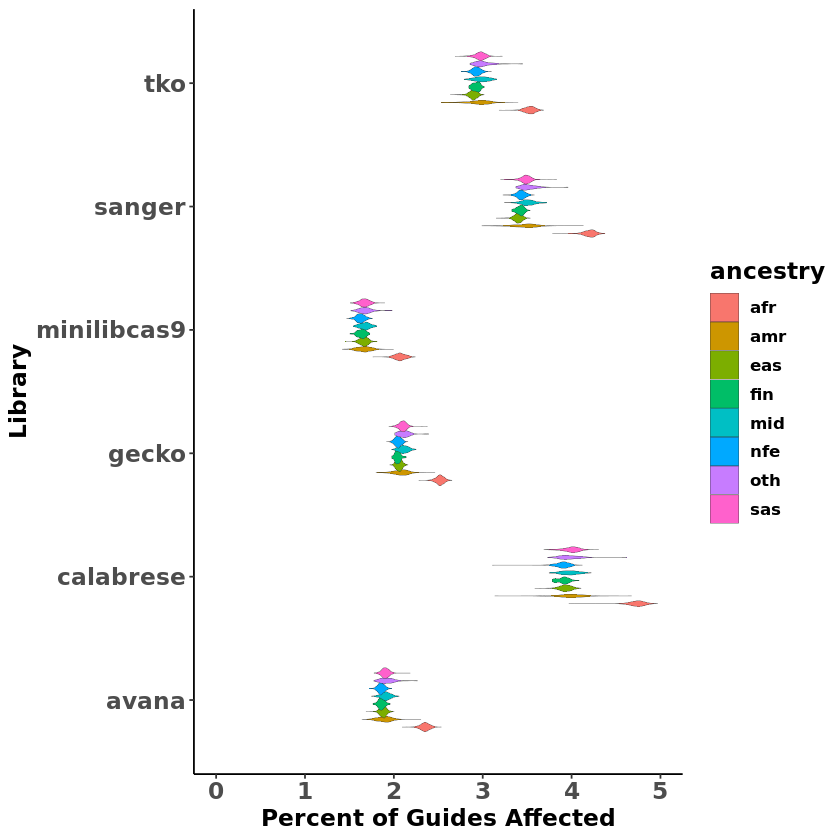

In [20]:
#draw the violin plot

ggplot(dataframe.for.plotting, aes(x=library, y=percent_affected, fill=ancestry)) +
geom_violin(position = position_dodge(width=.5), lwd=0.1) +
theme_bw() + 
scale_color_brewer(palette = "Spectral") +
guides(color = guide_legend(reverse=TRUE)) +

ylab("Percent of Guides Affected") +
xlab("Library") +

theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +

theme(axis.text=element_text(size=12), axis.title=element_text(size=14,face="bold")) +
theme(axis.text.x = element_text(face="bold", size=14), axis.text.y = element_text(face="bold", size=14)) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
) +

coord_flip() +
  
scale_y_continuous(limits = c(0, 5))

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("affected_guides_per_ancestry_group.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp affected_guides_per_ancestry_group.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


In [ ]:
#####Next Step: Make a better looking figure!!!